In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lfwpeople/pairsDevTrain.txt
/kaggle/input/lfwpeople/lfw-funneled.tgz
/kaggle/input/lfwpeople/pairsDevTest.txt
/kaggle/input/lfwpeople/pairs.txt


In [87]:
import os
import tarfile
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.optim as optim

In [88]:
# with open('/kaggle/input/lfwpeople/pairs.txt', 'r') as file:
#     data = file.read()
#     print(data)

In [89]:
# with open('/kaggle/input/lfwpeople/pairsDevTrain.txt', 'r') as file:
#     data = file.read()
#     print(data)

In [90]:
# Path to your tar file
tar_path = '/kaggle/input/lfwpeople/lfw-funneled.tgz'

# Open the tar file
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall()


In [91]:
folder_path = "/kaggle/working/lfw_funneled" 

# List all items (files and folders) within the specified folder
items = os.listdir(folder_path)
print(len(items))

dir_count = 0
file_count = 0

for item in items:
    full_path = os.path.join(folder_path, item)
    if os.path.isdir(full_path):
        dir_count += 1
#         print(item)
    else:
        file_count += 1
#         print(item)
print(dir_count)
print(file_count)

5760
5749
11


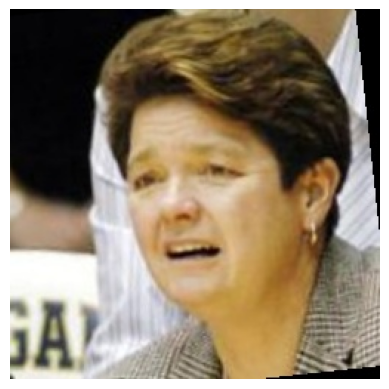

In [92]:
img = Image.open('/kaggle/working/lfw_funneled/Sue_Guevara/Sue_Guevara_0001.jpg')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [93]:
import random

def load_pairs(file_path):
    pairs = []
    with open(file_path, 'r') as f:
        for line in f.readlines()[1:]:  # Skip the header
            pair = line.strip().split()
            pairs.append(pair)
    return pairs

# Load training and testing pairs
train_pairs = load_pairs("/kaggle/input/lfwpeople/pairsDevTrain.txt")
test_pairs = load_pairs("/kaggle/input/lfwpeople/pairsDevTest.txt")

random.shuffle(train_pairs)

split_ratio = 0.2
split_index = int(len(train_pairs) * split_ratio)

# Split into train and validation pairs
validation_pairs = train_pairs[:split_index]
train_pairs = train_pairs[split_index:]

print(f"Number of training pairs: {len(train_pairs)}")
print(f"Number of validation pairs: {len(validation_pairs)}")
print(f"Number of Test pairs: {len(test_pairs)}")

Number of training pairs: 1760
Number of validation pairs: 440
Number of Test pairs: 1000


# Create Dataset Class

In [94]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image

class LFWDataset(torch.utils.data.Dataset):
    def __init__(self, pairs, root_dir, transform=None):
        self.pairs = pairs
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        
        if len(pair) == 3:  # Positive pair
            img1_path = os.path.join(self.root_dir, pair[0], f"{pair[0]}_{int(pair[1]):04d}.jpg")
            img2_path = os.path.join(self.root_dir, pair[0], f"{pair[0]}_{int(pair[2]):04d}.jpg")
            label = 0  # Same person
        else:  # Negative pair
            img1_path = os.path.join(self.root_dir, pair[0], f"{pair[0]}_{int(pair[1]):04d}.jpg")
            img2_path = os.path.join(self.root_dir, pair[2], f"{pair[2]}_{int(pair[3]):04d}.jpg")
            label = 1  # Different people

        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

lfw_dir = "/kaggle/working/lfw_funneled"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Create dataset instances
train_dataset = LFWDataset(train_pairs, root_dir=lfw_dir, transform=transform)
validation_dataset = LFWDataset(validation_pairs, root_dir=lfw_dir, transform=transform)
test_dataset = LFWDataset(test_pairs, root_dir=lfw_dir, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


# Build the Model

In [97]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3)
        
        # Dummy input to calculate the output size of the last conv layer
        self._to_linear = None
        self.convs(torch.randn(1, 3, 128, 128))
        
        # Define fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 128)  # Embedding size

    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]  # Calculate the output size
        
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Embedding vector
        return x

# Create the Loss Function

In [98]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss


# Train the Model

In [100]:
threshold = 0.5

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5

for epoch in range(num_epochs):
    model.train() # Turns on dropout and batch normalization layers update their running estimates of mean and variance
    running_loss = 0.0 
    
    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        
        optimizer.zero_grad()
        output1 = model(img1)
        output2 = model(img2)
        
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    model.eval() # Turn off dropout and estimates are used instead of computing them from the current batch
    labels = []
    predictions = []

    with torch.no_grad():
        for img1, img2, label in validation_loader:
            img1, img2 = img1.to(device), img2.to(device)
            
            output1 = model(img1)
            output2 = model(img2)
            
            euclidean_distance = F.pairwise_distance(output1, output2)
            prediction = (euclidean_distance > threshold).float()
            
            labels.extend(label.cpu().numpy())
            predictions.extend(prediction.cpu().numpy())

    # Calculate validation accuracy
    validation_accuracy = accuracy_score(labels, predictions)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {validation_accuracy:.4f}")
    

Epoch [1/5], Loss: 0.5871, Accuracy: 0.5932
Epoch [2/5], Loss: 0.2093, Accuracy: 0.6386
Epoch [3/5], Loss: 0.1936, Accuracy: 0.7091
Epoch [4/5], Loss: 0.1715, Accuracy: 0.6864
Epoch [5/5], Loss: 0.1531, Accuracy: 0.7182


# Evaluate the Model

In [102]:
model.eval()
labels = []
predictions = []

with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2 = img1.to(device), img2.to(device)
        output1 = model(img1)
        output2 = model(img2)
        
        euclidean_distance = F.pairwise_distance(output1, output2)
        prediction = (euclidean_distance > threshold).float()
        
        labels.extend(label.cpu().numpy())
        predictions.extend(prediction.cpu().numpy())

accuracy = accuracy_score(labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7050
